In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [2]:
def unix_nano_to_datetime(nanoseconds):
    unix_time_seconds = nanoseconds // 1e9
    ns_part = nanoseconds % 1e9
    dt = datetime.utcfromtimestamp(unix_time_seconds)
    formatted_dt = dt.strftime('%H:%M:%S') + '.' + '{:03d}'.format(int(ns_part / 1e6)) + '{:03d}'.format(int(ns_part % 1e6))
    return formatted_dt

def get_LPM(F):
    return (F)/7.5 

In [3]:
def analyse(file_path):

    df = pd.read_csv(file_path).iloc[50:-50]
    df['time'] = df.index
    df['sensor'] = df['Timestamp (unix time nano seconds)'].str.replace(' ', '')
    df = df[['time', 'sensor']]
    df = df.reset_index(drop=True)

    # Compute GPMs
    omega_times = list(df[df.sensor=='Omega'].time)
    hall_times = list(df[df.sensor=='Hall'].time)

    for i in range(len(omega_times)-1):
        frequency = 1/(omega_times[i+1]-omega_times[i])*1e9
        if i==0: 
            df.loc[df.time>=0, 'omega_freq'] = frequency
            df.loc[df.time>=0, 'omega_GPM'] = 0.1/(omega_times[i+1]-omega_times[i])*60*1e9
        df.loc[df.time>=omega_times[i], 'omega_freq'] = frequency
        df.loc[df.time>=omega_times[i], 'omega_GPM'] = 0.1/(omega_times[i+1]-omega_times[i])*60*1e9

    for i in range(len(hall_times)-1):
        frequency = 1/(hall_times[i+1]-hall_times[i])*1e9 * 2
        if i==0: 
            df.loc[df.time>=0, 'hall_freq'] = frequency/2
            df.loc[df.time>=0, 'hall_GPM'] = get_LPM(frequency) * 0.264172
        df.loc[df.time>=hall_times[i], 'hall_freq'] = frequency/2
        df.loc[df.time>=hall_times[i], 'hall_GPM'] = get_LPM(frequency) * 0.264172

    # Remove errors
    df.loc[df['hall_GPM'] > 10, 'hall_GPM'] = np.nan
    df.loc[df['omega_GPM'] > 10, 'omega_GPM'] = np.nan

    # Calibrate using bias correction
    bias = df.hall_GPM.mean() - df.omega_GPM.mean()
    df.hall_GPM = df.hall_GPM - bias

    # display(df)

    # Plot results
    plt.plot(df.omega_GPM, alpha=0.5, label='Omega', color='red')
    plt.plot(df.hall_GPM, alpha=0.4, label='Hall', color='grey')
    plt.title(file_path.split('/')[-1] + f' with {round(bias,3)} bias correction')
    plt.ylim([min(min(list(df.omega_GPM)),min(list(df.hall_GPM)))-0.2, max(max(list(df.omega_GPM)),max(list(df.hall_GPM)))+0.2])
    plt.ylabel('GPM')
    plt.xlabel('Time')
    plt.legend()
    plt.show()


**************************************************
Frequency: 5 Hz
**************************************************


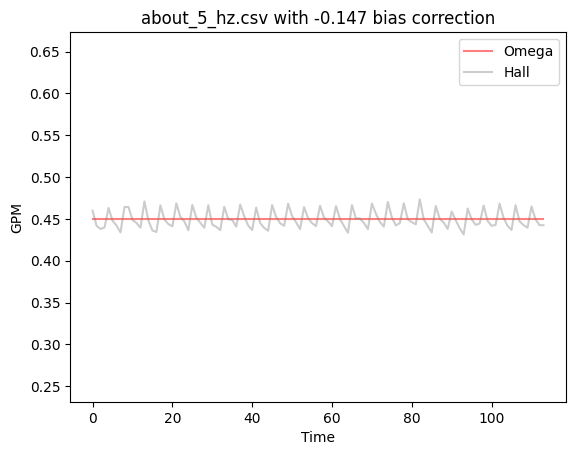

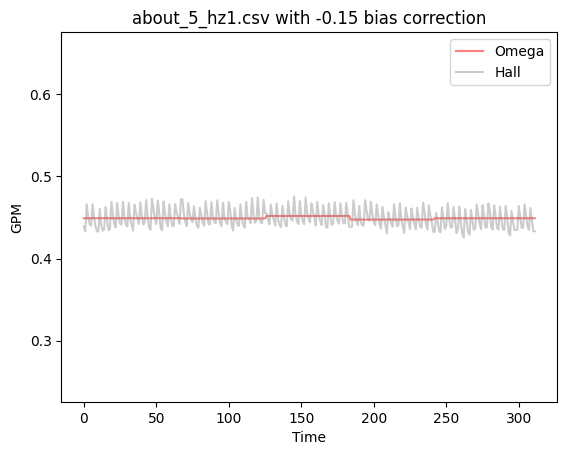

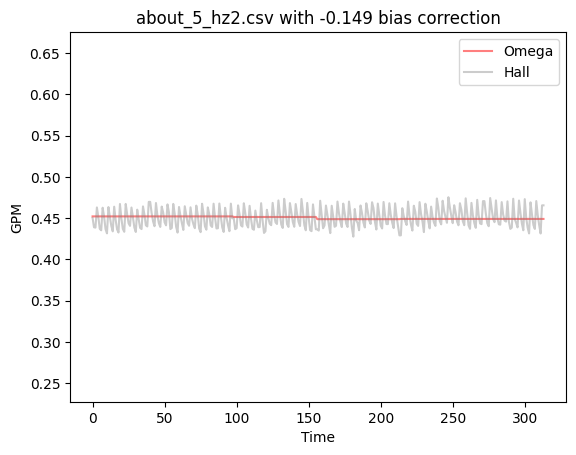

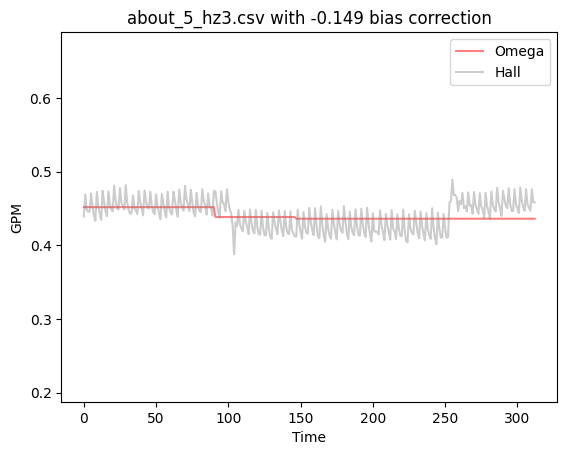

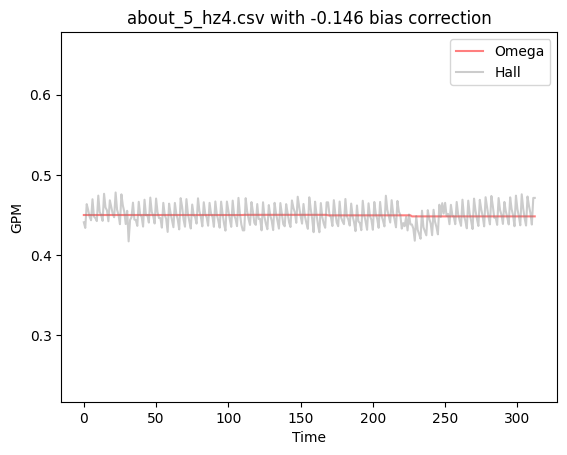

**************************************************
Frequency: 11 Hz
**************************************************


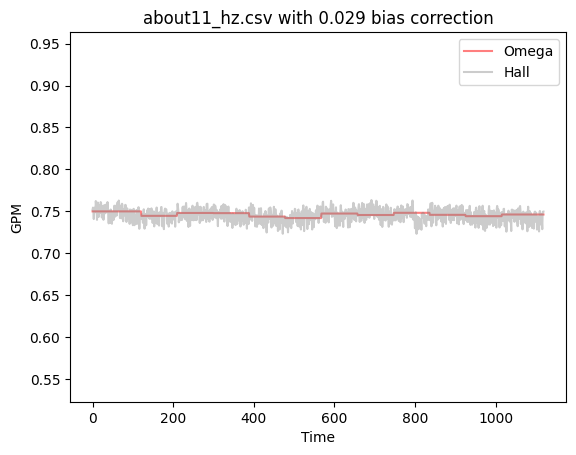

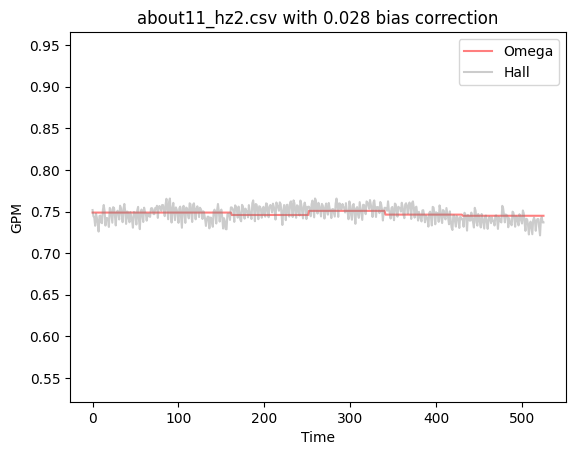

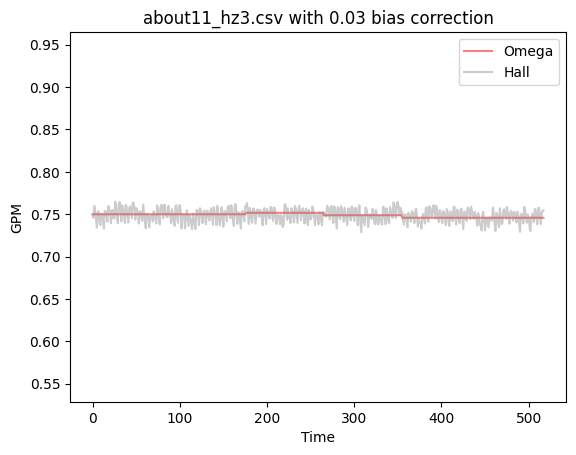

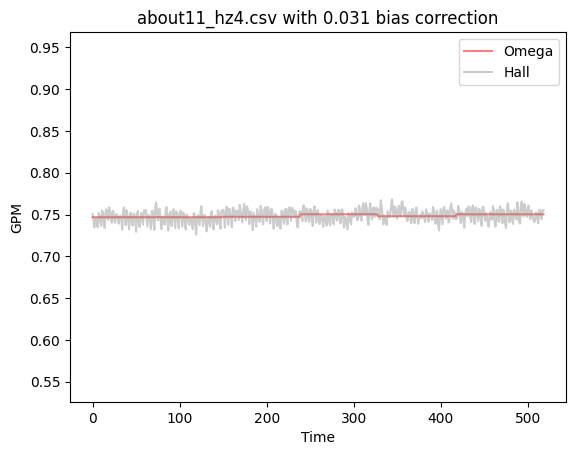

**************************************************
Frequency: 20 Hz
**************************************************


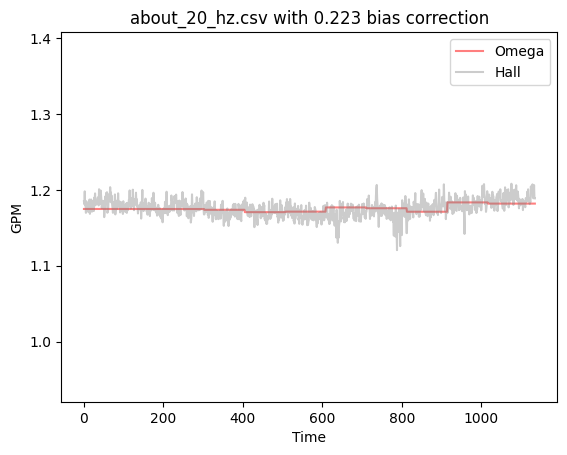

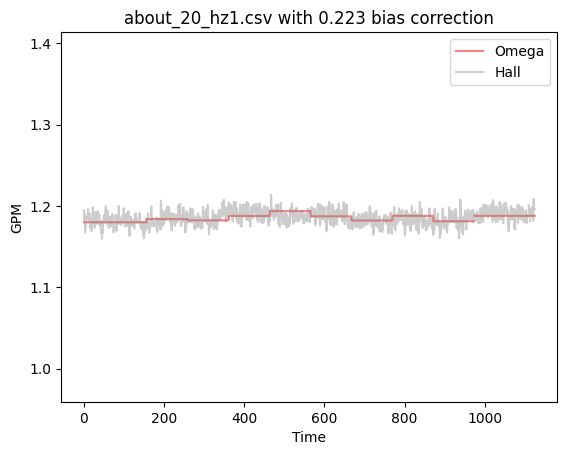

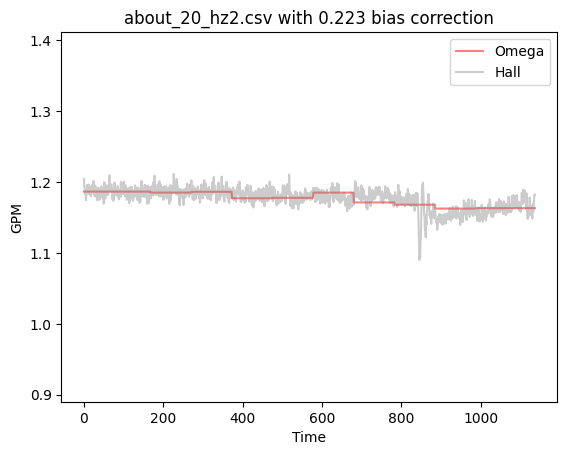

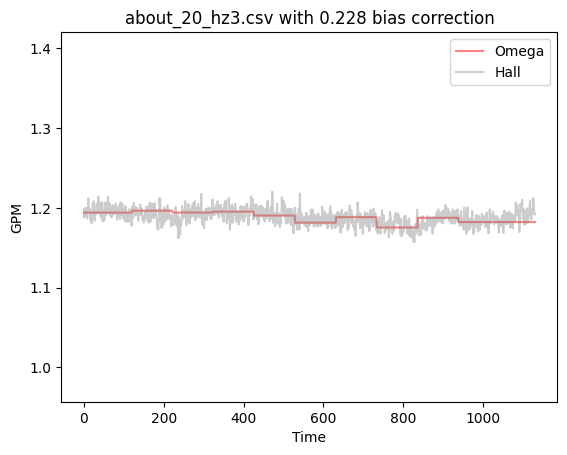

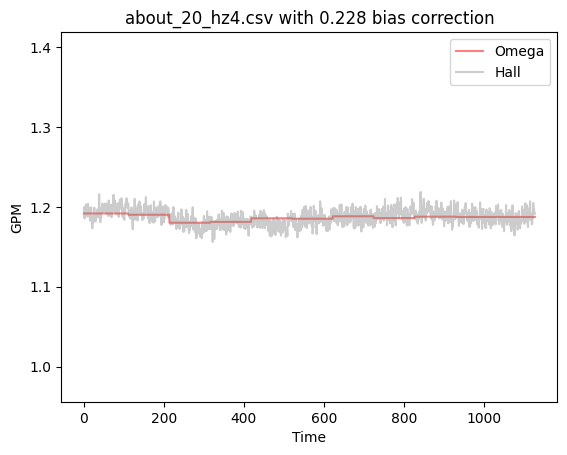

**************************************************
Frequency: 30 Hz
**************************************************


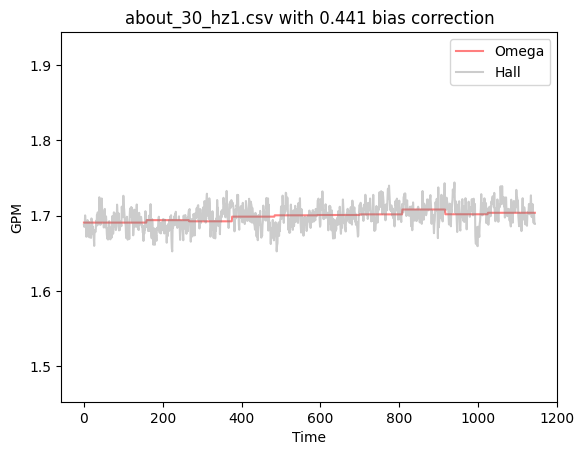

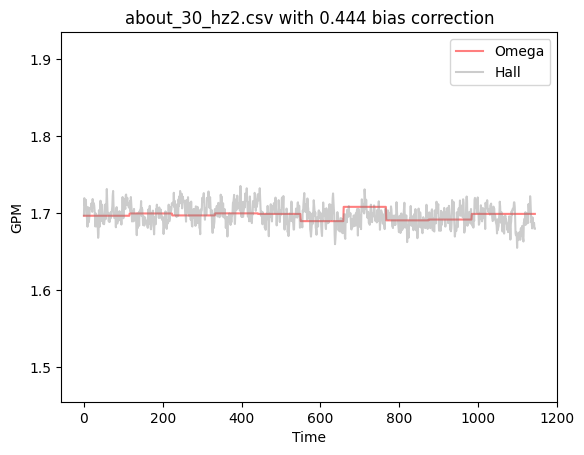

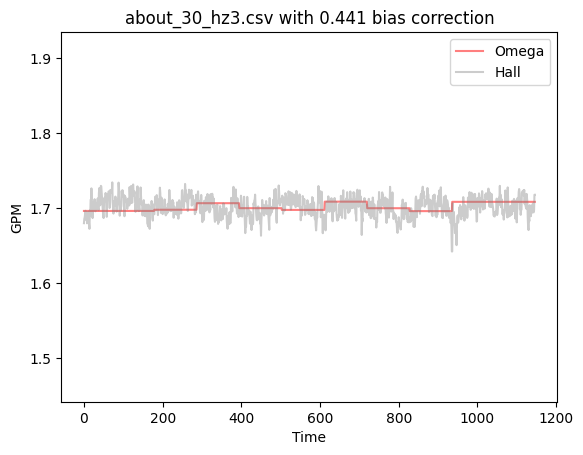

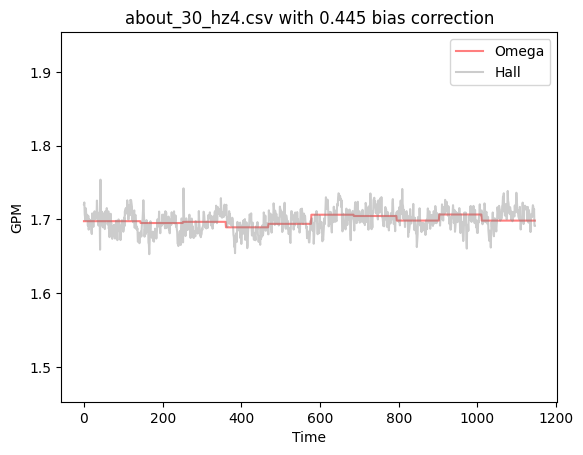

**************************************************
Frequency: 40 Hz
**************************************************


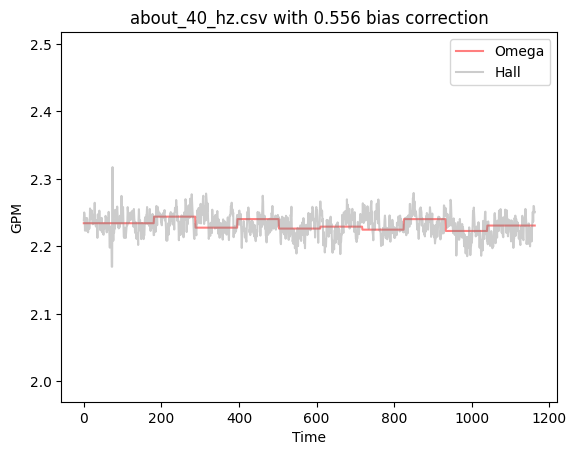

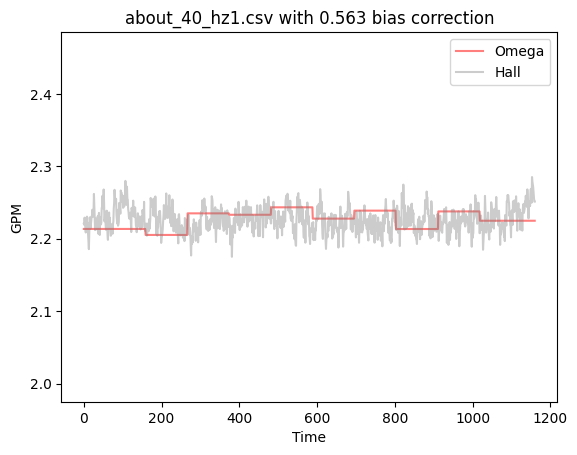

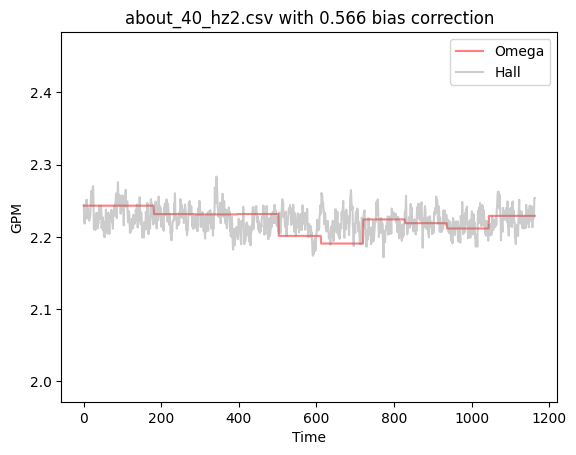

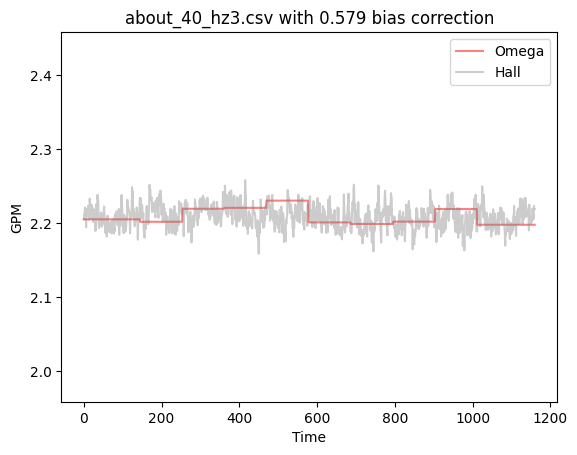

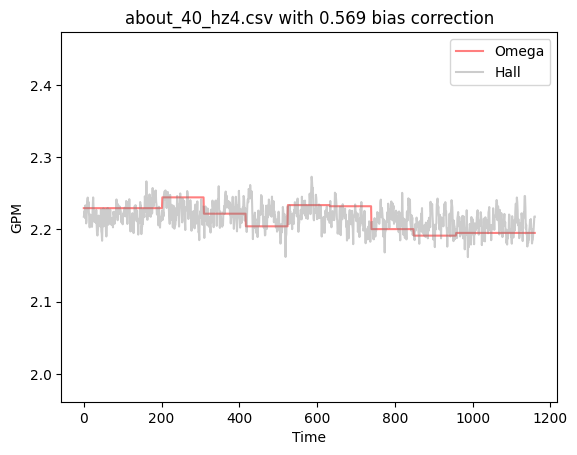

**************************************************
Frequency: 50 Hz
**************************************************


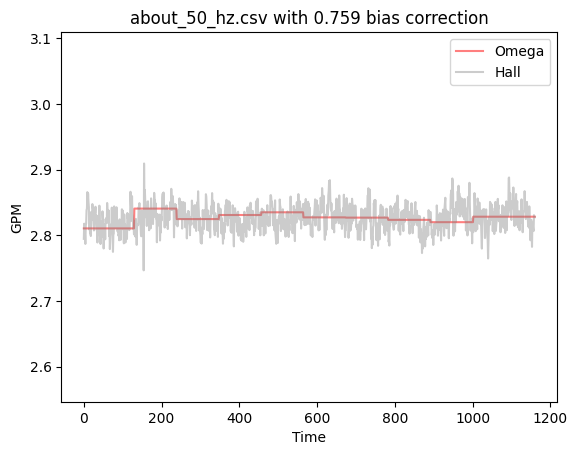

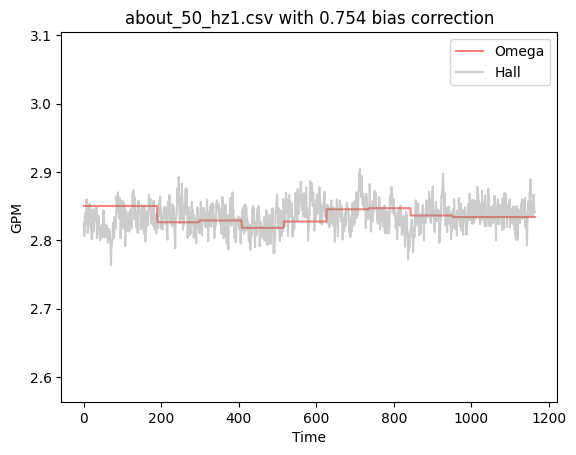

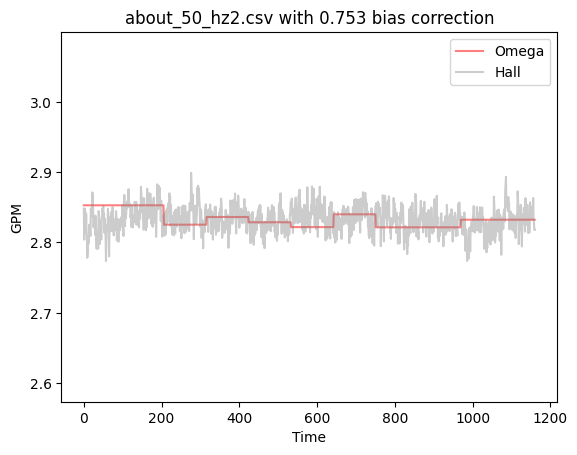

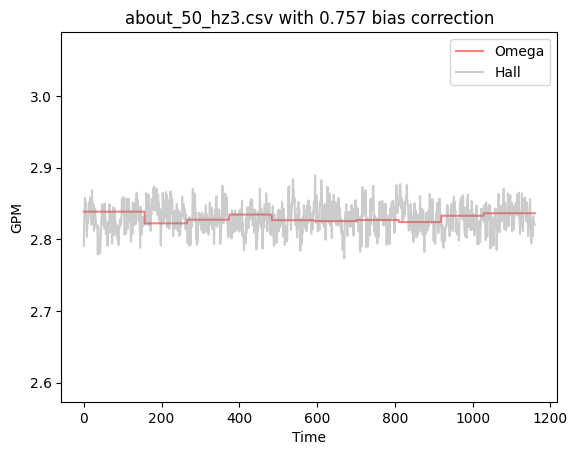

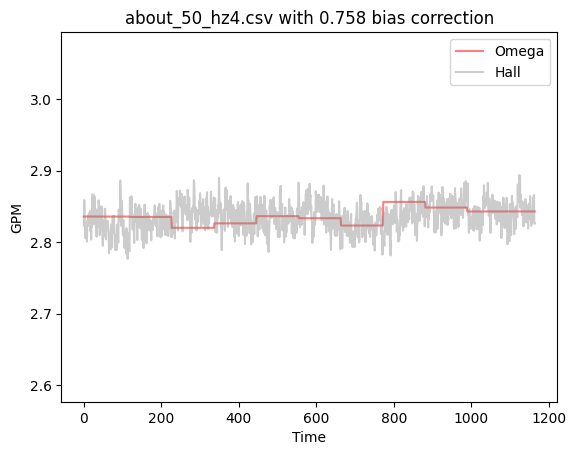

**************************************************
Frequency: 60 Hz
**************************************************


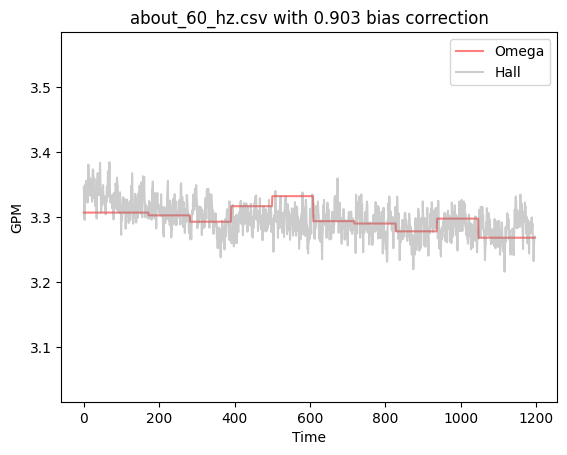

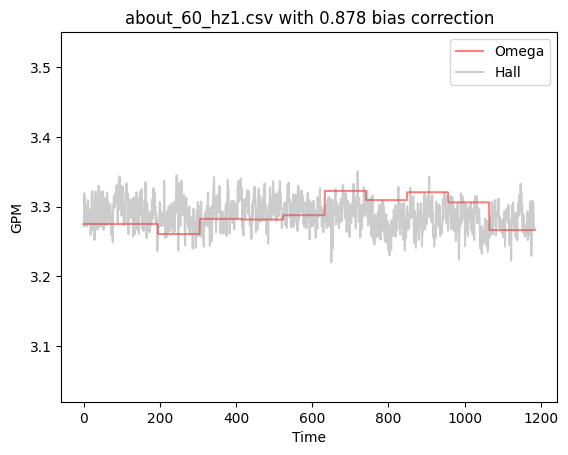

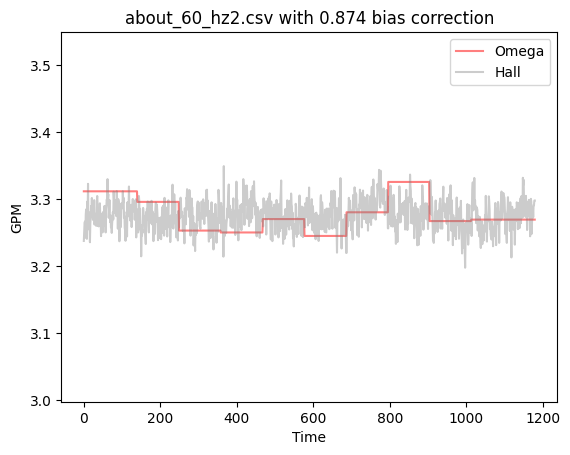

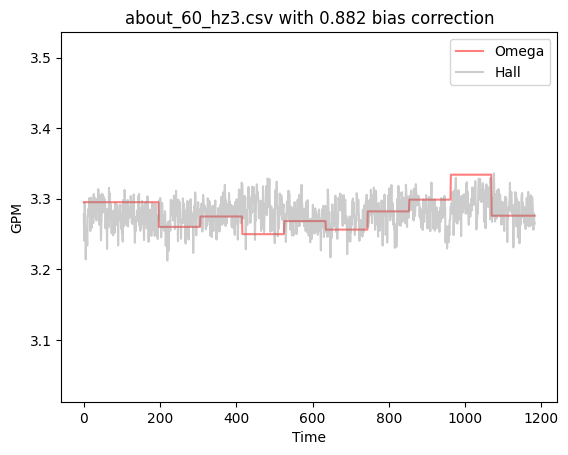

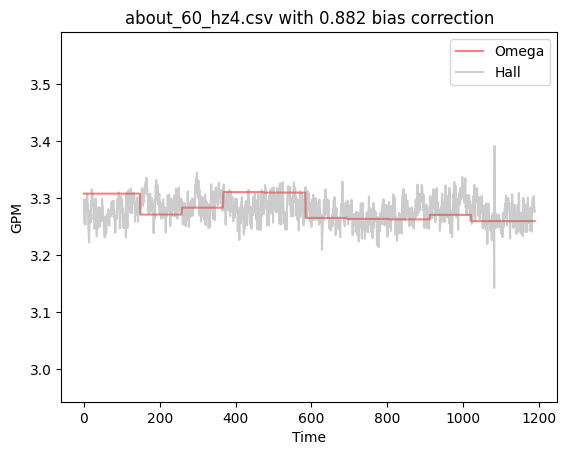

In [4]:
freqs = [5,11,20,30,40,50,60]
for f in freqs:
    print('*'*50)
    print(f'Frequency: {f} Hz')
    print('*'*50)
    for i in range(5):
        try:
            if i>0:
                if f!=11:
                    analyse(f'flow_data/about_{f}/about_{f}_hz{i}.csv')
                else:   
                    analyse(f'flow_data/about_{f}/about{f}_hz{i}.csv')
            elif f!=30:
                if f!=11:
                    analyse(f'flow_data/about_{f}/about_{f}_hz.csv')
                else:   
                    analyse(f'flow_data/about_{f}/about{f}_hz.csv')
        except:
            continue